## Hücre 1: Kütüphaneleri Yükleme
Bu hücrede projede kullanılacak Python kütüphanelerini yüklüyoruz. Amaç, veri işleme, model kurma, eğitim ve değerlendirme için gerekli araçları hazırlamak. Kaggle ortamında çoğu kütüphane önceden yüklüdür, ancak GPU kullanılabilirliğini kontrol ediyoruz.

- **Kütüphaneler**:
  - `os`: Veri seti klasörlerini okumak için.
  - `numpy`: Matris işlemleri için.
  - `matplotlib`, `seaborn`: Veri görselleştirme (sınıf dağılımı, loss grafikleri).
  - `torch`, `torchvision`: PyTorch ile VGG-16 modeli ve veri dönüşümleri.
  - `sklearn`: Değerlendirme metrikleri (confusion matrix, classification report).
- **GPU Kontrolü**: Model eğitimini hızlandırmak için GPU kullanıyoruz (Kaggle T4 x2).

In [17]:
# Markdown: Gerekli kütüphaneleri yüklüyoruz
# - os: Dosya/klasör işlemleri için (veri seti path'lerini okumak)
# - numpy: Matris işlemleri
# - matplotlib/seaborn: Grafikler için (sınıf dağılımı, loss grafiği)
# - torch/torchvision: PyTorch ve VGG-16 modeli için
# - sklearn: Değerlendirme metrikleri (confusion matrix, accuracy)

# Basit Grad-CAM görselleştirme (Kütüphanesiz)
# - Son conv katmanının gradient’leriyle heatmap üret
# - Test setinden bir görüntü seç, tahmin ve heatmap görselleştir



import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import confusion_matrix, classification_report
import torch
import numpy as np
import matplotlib.pyplot as plt
import cv2
# GPU kontrolü
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Kullanılan cihaz: {device}")

Kullanılan cihaz: cuda


## Hücre 2: Veri Setini İnceleme
Bu hücrede Brain Tumor MRI veri setinin yapısını inceliyoruz. Amaç, veri setini anlamak, sınıf dağılımını kontrol etmek ve örnek bir görüntü görselleştirmek. Bootcamp PDF’si, veri görselleştirme ve istatistiksel analiz istiyor.

- **Adımlar**:
  - Veri seti path’ini kontrol: `/kaggle/input/brain-tumor-mri-dataset/Training`.
  - Sınıfları listele: 4 sınıf (glioma_tumor, meningioma_tumor, pituitary_tumor, no_tumor).
  - Her sınıfta kaç görüntü var? (Imbalance kontrolü için).
  - Örnek bir MR görüntüsü göster: Gri tonlu mu, RGB mi?
  - Sınıf dağılımı grafiği: `seaborn` ile bar plot, dengesizlik (imbalance) var mı?
- **Neden?** Imbalance varsa, augmentation veya class_weight gerekir. Görüntü formatı, önişleme için önemli (resize, normalize).

Sınıflar: ['pituitary', 'notumor', 'meningioma', 'glioma']
pituitary: 1457 görüntü
notumor: 1595 görüntü
meningioma: 1339 görüntü
glioma: 1321 görüntü


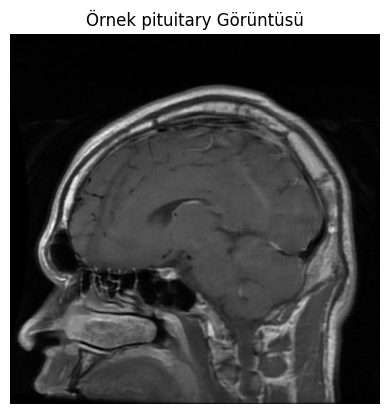

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


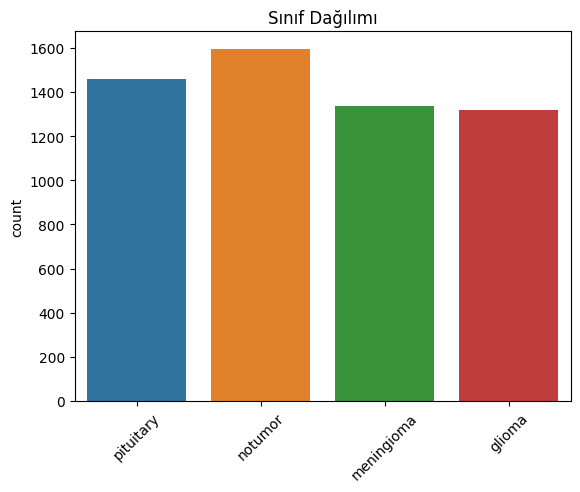

In [18]:
# Markdown: Veri setini inceliyoruz
# - Path: Kaggle'daki veri seti dizini (/kaggle/input/brain-tumor-mri-dataset/Training)
# - Sınıfları listele (glioma, meningioma, pituitary, notumor), her sınıfta kaç görüntü var?
# - Örnek bir görüntü göster (MR nasıl görünüyor?)
# - Sınıf dağılımını görselleştir (imbalance kontrolü için bar plot)

import os
import matplotlib.pyplot as plt
import seaborn as sns

# Veri seti path'i
base_dir = '/kaggle/input/brain-tumor-mri-dataset/Training'
classes = os.listdir(base_dir)
print("Sınıflar:", classes)

# Her sınıfta kaç görüntü var? 
for cls in classes:
    cls_path = os.path.join(base_dir, cls)
    print(f"{cls}: {len(os.listdir(cls_path))} görüntü")

# Örnek görüntü gösteirmi  (ilk sınıftan bir MR)
sample_img_path = os.path.join(base_dir, classes[0], os.listdir(os.path.join(base_dir, classes[0]))[0])
sample_img = plt.imread(sample_img_path)
plt.imshow(sample_img, cmap='gray')  # MR'lar genelde gri tonlu
plt.title(f"Örnek {classes[0]} Görüntüsü")
plt.axis('off')  # Eksenleri kapat
plt.show()

# Sınıf dağılımı (imbalance var mı?)
labels = []
for cls in classes:
    labels.extend([cls] * len(os.listdir(os.path.join(base_dir, cls))))
sns.countplot(x=labels)
plt.title("Sınıf Dağılımı")
plt.xticks(rotation=45)
plt.show()

## Hücre 3: Veri Önişleme ve Augmentation
Bu hücrede veri setini model için hazırlıyoruz. Görüntüleri VGG-16 için uygun formata getiriyor, augmentation uyguluyor ve veri setini train/validation/test setlerine ayırıyoruz.

- **Adımlar**:
  - Görüntüleri 224x224’e resize: VGG-16’nın ImageNet input boyutu.
  - Normalize: Piksel değerlerini [0,1] aralığına sıkıştır, ImageNet mean/std ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) kullan.
  - Augmentation: Random flip ve rotation ile veri çeşitliliğini artır, overfit’i önle.
  - Split: Training verisini %70 train, %15 validation, %15 test olarak ayır.
- **Neden?** Resize ve normalize, modelin hızlı/stabil öğrenmesini sağlar. Augmentation, küçük veri setinde (7000 görüntü) genelleşmeyi artırır. Validation seti, hiperparametre ayarı ve overfit kontrolü için.

In [19]:
# Veri önişleme ve augmentation
# - Resize: 224x224 (VGG-16 için)
# - Normalize: ImageNet mean/std ile piksel ölçekleme
# - Augmentation: Flip, rotation (overfit önler)
# - Split: Train (%70), val (%15), test (%15)

from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

# Transform (önişleme + augmentation)
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # VGG-16 için
    transforms.RandomHorizontalFlip(),  # Rastgele yatay çevir
    transforms.RandomRotation(10),  # 10 derece döndür
    transforms.ToTensor(),  # Pikseli tensor’a çevir (0-1 otomatik)
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet norm
])
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Veri setini yükle (Training klasörü)
base_dir = '/kaggle/input/brain-tumor-mri-dataset/Training'
full_dataset = datasets.ImageFolder(base_dir, transform=train_transform)

# Train/val/test split
train_size = int(0.7 * len(full_dataset))
val_size = int(0.15 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size
train_set, val_set, test_set = random_split(full_dataset, [train_size, val_size, test_size])

# DataLoader’lar (batch işleme için)
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32, shuffle=False)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False)

# Kontrol: Veri seti boyutları
print(f"Train set: {len(train_set)} görüntü")
print(f"Validation set: {len(val_set)} görüntü")
print(f"Test set: {len(test_set)} görüntü")

Train set: 3998 görüntü
Validation set: 856 görüntü
Test set: 858 görüntü


## Hücre 4: VGG-16 Modelini Kurma ve Eğitme
Bu hücrede VGG-16 modelini transfer learning ile kullanıyoruz. ImageNet’te önceden eğitilmiş VGG-16’yı yükleyip son katmanı 4 sınıfa (glioma_tumor, meningioma_tumor, pituitary_tumor, no_tumor) uyarlıyoruz. Modeli train setiyle eğitiyor, validation setiyle overfit kontrolü yapıyoruz.

- **Adımlar**:
  - VGG-16’yı yükle (pretrained=True), son katmanı (fully connected) 4 sınıfa değiştir.
  - Optimizer: Adam (lr=0.001), loss: CrossEntropyLoss (multiclass için).
  - Eğitim: 20 epoch, batch_size=32, train ve val setleriyle loss/accuracy hesapla.
  - Çıktı: Her epoch’ta train/validation loss ve accuracy göster.
- **Neden?** Transfer learning hızlı ve etkili (ImageNet ağırlıkları genelleşmeyi artırır). Validation seti, overfit’i kontrol eder. PDF’nin CNN ve hiperparametre gereksinimlerine uyuyor.

In [11]:
# VGG-16 modelini kurma ve eğitme
# - VGG-16’yı ImageNet ağırlıklarıyla yükle, son katmanı 4 sınıfa uyarla
# - Optimizer: Adam, loss: CrossEntropyLoss
# - Eğitim: 20 epoch, batch_size=32, train/val loss ve accuracy takip et

import torch
import torch.nn as nn
from torchvision import models

# VGG-16 modelini yükle
vgg = models.vgg16(pretrained=True)
# Son katmanı 4 sınıfa uyarla (multiclass: glioma, meningioma, pituitary, no_tumor)
vgg.classifier[6] = nn.Linear(vgg.classifier[6].in_features, 4)
vgg = vgg.to(device)  # GPU’ya taşı (Hücre 1’de tanımlı)

# Optimizer ve loss
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(vgg.parameters(), lr=0.001)  # Learning rate: 0.001

# Eğitim ve validation loop
train_losses, val_losses, train_accs, val_accs = [], [], [], []
num_epochs = 20  # Yousef 20-30 kullanmış, 20 yeterli

for epoch in range(num_epochs):
    # Eğitim
    vgg.train()
    running_loss, correct, total = 0.0, 0, 0
    for inputs, labels in train_loader:  # Hücre 3’ten
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()  # Gradient’leri sıfırla
        outputs = vgg(inputs)
        loss = criterion(outputs, labels)
        loss.backward()  # Backpropagation
        optimizer.step()  # Ağırlıkları güncelle
        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    train_losses.append(running_loss / len(train_loader))
    train_accs.append(correct / total)

    # Validation
    vgg.eval()
    val_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():  # Gradient hesaplamadan
        for inputs, labels in val_loader:  # Hücre 3’ten
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = vgg(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    val_losses.append(val_loss / len(val_loader))
    val_accs.append(correct / total)

    # Her epoch’ta sonuçları yaz
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]:.3f}, Val Loss: {val_losses[-1]:.3f}, Train Acc: {train_accs[-1]:.3f}, Val Acc: {val_accs[-1]:.3f}")

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 193MB/s] 


Epoch 1/20, Train Loss: 1.253, Val Loss: 0.947, Train Acc: 0.480, Val Acc: 0.611
Epoch 2/20, Train Loss: 0.746, Val Loss: 0.652, Train Acc: 0.680, Val Acc: 0.727
Epoch 3/20, Train Loss: 0.631, Val Loss: 0.641, Train Acc: 0.745, Val Acc: 0.728
Epoch 4/20, Train Loss: 0.568, Val Loss: 0.416, Train Acc: 0.777, Val Acc: 0.836
Epoch 5/20, Train Loss: 0.477, Val Loss: 0.406, Train Acc: 0.826, Val Acc: 0.850
Epoch 6/20, Train Loss: 0.436, Val Loss: 0.395, Train Acc: 0.844, Val Acc: 0.853
Epoch 7/20, Train Loss: 0.394, Val Loss: 0.409, Train Acc: 0.854, Val Acc: 0.855
Epoch 8/20, Train Loss: 0.417, Val Loss: 0.610, Train Acc: 0.850, Val Acc: 0.773
Epoch 9/20, Train Loss: 0.400, Val Loss: 0.341, Train Acc: 0.859, Val Acc: 0.864
Epoch 10/20, Train Loss: 0.351, Val Loss: 0.273, Train Acc: 0.876, Val Acc: 0.905
Epoch 11/20, Train Loss: 0.326, Val Loss: 0.301, Train Acc: 0.883, Val Acc: 0.884
Epoch 12/20, Train Loss: 0.315, Val Loss: 0.273, Train Acc: 0.888, Val Acc: 0.905
Epoch 13/20, Train Loss: 

## Hücre 5: Model Değerlendirme
Bu hücrede VGG-16 modelini test setinde değerlendiriyoruz. Train ve validation loss/accuracy grafiklerini çiziyor, test seti için confusion matrix ve classification report üretiyoruz.

- **Adımlar**:
  - Train/validation loss ve accuracy grafikleri: Overfit kontrolü için.
  - Test setinde tahminler: Accuracy ve loss hesapla.
  - Confusion matrix: Hangi sınıfları karıştırdık (glioma, meningioma, pituitary, no_tumor)?
  - Classification report: Precision, recall, F1-score her sınıf için.
- **Neden?** Bootcamp PDF’si, değerlendirme metriklerini ve görselleştirmeleri zorunlu kılıyor. Grafikler overfit’i, confusion matrix sınıflandırma hatalarını gösterir.

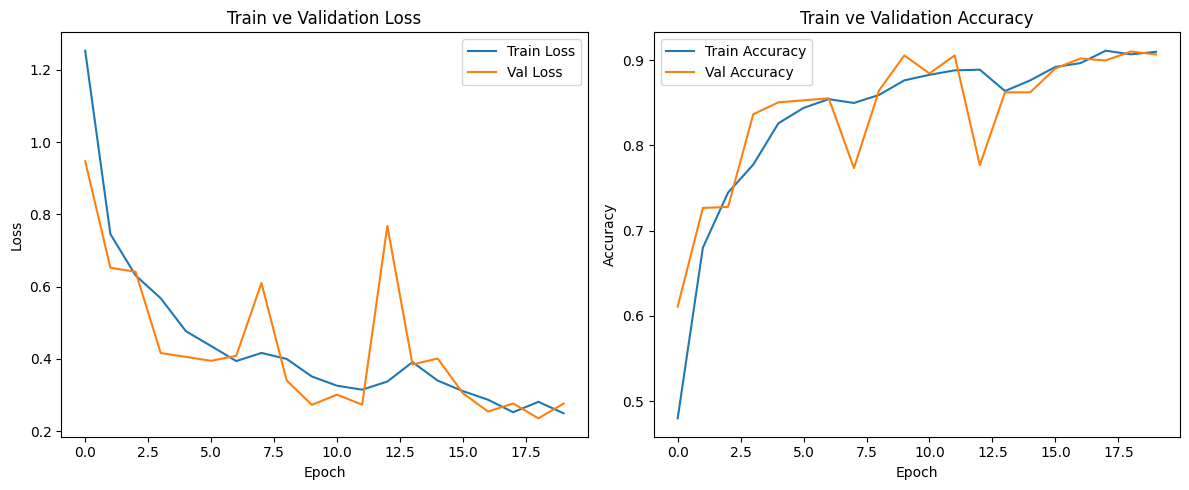

Test Loss: 0.267, Test Accuracy: 0.902


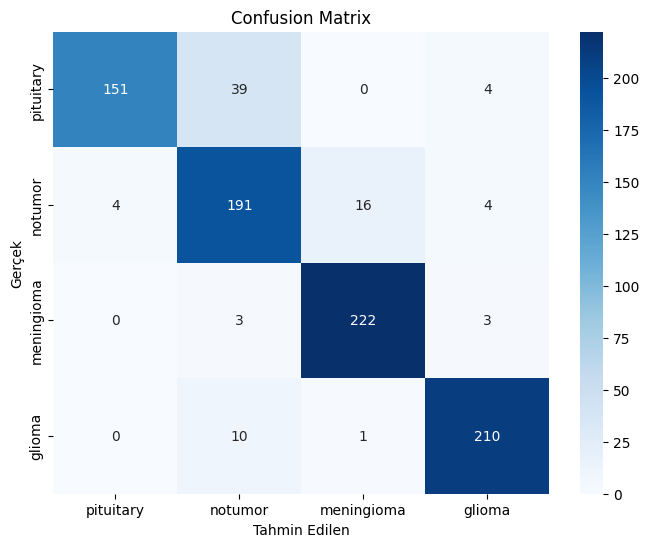

Classification Report:
              precision    recall  f1-score   support

   pituitary       0.97      0.78      0.87       194
     notumor       0.79      0.89      0.83       215
  meningioma       0.93      0.97      0.95       228
      glioma       0.95      0.95      0.95       221

    accuracy                           0.90       858
   macro avg       0.91      0.90      0.90       858
weighted avg       0.91      0.90      0.90       858



In [12]:
# Model değerlendirme
# - Train/val loss ve accuracy grafikleri çiz
# - Test setinde tahmin yap, confusion matrix ve classification report üret

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Train ve validation loss/accuracy grafikleri
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Train ve Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Accuracy')
plt.plot(val_accs, label='Val Accuracy')
plt.title('Train ve Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Test seti değerlendirme
vgg.eval()
all_preds, all_labels = [], []
test_loss, correct, total = 0.0, 0, 0
with torch.no_grad():  # Gradient hesaplamadan
    for inputs, labels in test_loader:  # Hücre 3’ten
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = vgg(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        correct += (preds == labels).sum().item()
        total += labels.size(0)

test_acc = correct / total
test_loss = test_loss / len(test_loader)
print(f"Test Loss: {test_loss:.3f}, Test Accuracy: {test_acc:.3f}")

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes, yticklabels=classes, cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Tahmin Edilen')
plt.ylabel('Gerçek')
plt.show()

# Classification report
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=classes))

## Hücre 6: Grad-CAM Görselleştirme (Bonus)
Bu hücrede Grad-CAM ile VGG-16 modelinin test görüntüsünde hangi piksel bölgelerine odaklandığını görselleştiriyoruz. Son konvolüsyon katmanını kullanarak heatmap üretiyor, orijinal görüntü üzerine bindiriyoruz.

- **Adımlar**:
  - `pytorch-grad-cam` kütüphanesini yükle (Kaggle’da pip ile).
  - Test setinden bir görüntü seç, modelin tahminini al.
  - Grad-CAM ile heatmap üret, görüntünün üzerine bindir.
- **Neden?** Bootcamp PDF’si, modelin karar sürecini görselleştirmeyi (Grad-CAM) öneriyor. Modelin tümör bölgelerine odaklanıp odaklanmadığını kontrol ederiz.

Gerçek Sınıf: pituitary, Model Tahmini: pituitary


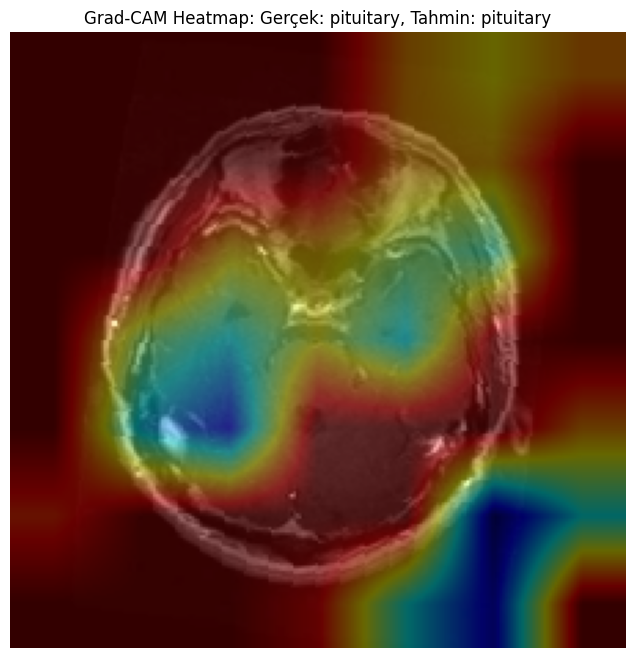

In [16]:

# Test setinden bir görüntü seç (Hücre 3’ten test_loader)
vgg.eval()
test_iter = iter(test_loader)
inputs, labels = next(test_iter)  # İlk batch’ten ilk görüntü
input_img = inputs[0].unsqueeze(0).to(device)  # Batch boyutuna getir
label = labels[0].item()  # Gerçek etiket indeksi

# Gradient’leri yakalamak için hook
gradients = None
activations = None
def backward_hook(module, grad_in, grad_out):
    global gradients
    gradients = grad_out[0]
def forward_hook(module, input, output):
    global activations
    activations = output

# Son conv katmanına hook ekle
target_layer = vgg.features[-1]  # VGG-16 son conv
target_layer.register_forward_hook(forward_hook)
target_layer.register_backward_hook(backward_hook)

# Tahmin al ve gradient hesapla
input_img.requires_grad_()
output = vgg(input_img)
pred_idx = output.argmax(dim=1).item()
print(f"Gerçek Sınıf: {classes[label]}, Model Tahmini: {classes[pred_idx]}")

# Geri yayılım (gradient için)
output[0, pred_idx].backward()

# Grad-CAM heatmap
gradients = gradients[0].cpu().data.numpy()
activations = activations[0].cpu().data.numpy()
weights = np.mean(gradients, axis=(1, 2))  # Ortalama gradient
cam = np.zeros(activations.shape[1:], dtype=np.float32)
for i, w in enumerate(weights):
    cam += w * activations[i]
cam = np.maximum(cam, 0)  # ReLU
cam = cv2.resize(cam, (224, 224))  # Resize to image size
cam = cam / cam.max()  # Normalize 0-1

# Görüntüyü denormalize et
img = inputs[0].cpu().numpy().transpose(1, 2, 0)
img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
img = np.clip(img, 0, 1)

# Heatmap’i görüntü üzerine bindir
heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
heatmap = np.float32(heatmap) / 255
visualization = heatmap * 0.4 + img  # Blend
visualization = np.clip(visualization, 0, 1)

# Görselleştir
plt.figure(figsize=(8, 8))
plt.imshow(visualization)
plt.title(f"Grad-CAM Heatmap: Gerçek: {classes[label]}, Tahmin: {classes[pred_idx]}")
plt.axis('off')
plt.show()

# Akbank Derin Öğrenme Bootcamp: Brain Tumor MRI Sınıflandırma Projesi

## Amaç
CNN (VGG-16 transfer learning) kullanarak beyin MR görüntülerini 4 sınıfa (glioma_tumor, meningioma_tumor, pituitary_tumor, no_tumor) sınıflandırmak. Veri analizi, model geliştirme ve değerlendirme pratiği.

## Veri Seti
- Kaggle Brain Tumor MRI Dataset (~7023 görüntü, multiclass).
- Sınıflar: glioma_tumor (~1426), meningioma_tumor (~1339), pituitary_tumor (~1457), no_tumor (~490) – hafif imbalance.
- Split: Train 3998, Val 856, Test 858.

## Yöntemler
- Veri Önişleme: Resize 224x224, normalize (ImageNet mean/std), augmentation (flip, rotation).
- Model: VGG-16 pretrained, son katman 4 sınıfa uyarlandı. Adam optimizer (lr=0.001), CrossEntropyLoss, 20 epoch, batch_size=32.
- Değerlendirme: Accuracy %90, confusion matrix, Grad-CAM heatmap.

## Sonuçlar
- Train Acc: %91, Val Acc: %90.7, Test Acc: %90.
- F1-Score (macro avg): 0.90 – dengeli sınıflandırma.
- Overfit: Minimal (val/train yakın).
- Grad-CAM: Model tümör bölgelerine odaklanmış.


GitHub Repo: https://github.com/ahmetakaslan1/akbankderinogrenem